# Northwind Database

### importing and overview of data

In [1]:
#importings
import sqlite3
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp
import researchpy as rp
import seaborn as sns
import warnings
from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
import pandas_profiling
InteractiveShell.ast_node_interactivity = "all"
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
conn = sqlite3.connect('Northwind_small.sqlite')
c = conn.cursor()

<img src="Northwind_ERD_updated.png" />

In [3]:
#selecting some data
c.execute("""SELECT ProductName, CategoryName, Product.UnitPrice, UnitsInStock, Supplier.Region
            , ShipName, Description, ReorderLevel, Notes, ShipRegion, OrderDate, BirthDate 
            , Discount, Customer.City, HireDate, Quantity
            FROM OrderDetail
            JOIN 'Order'
            ON 'Order'.Id = OrderDetail.OrderId
            INNER JOIN Product
            ON Product.Id = OrderDetail.ProductId
            JOIN Category
            On Category.Id = Product.CategoryId
            JOIN Employee
            on EmployeeId = Employee.Id
            JOIN Customer
            on Customer.Id = CustomerId
            Join Supplier
            on Supplier.Id = SupplierId
            
             ;""")
df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]
df.head(3)

,ProductName,CategoryName,UnitPrice,UnitsInStock,Region,ShipName,Description,ReorderLevel,Notes,ShipRegion,OrderDate,BirthDate,Discount,City,HireDate,Quantity
0,Queso Cabrales,Dairy Products,21.0,22,Southern Europe,Vins et alcools Chevalier,Cheeses,30,Steven Buchanan graduated from St. Andrews Uni...,Western Europe,2012-07-04,1987-03-04,0.0,Reims,2025-10-17,12
1,Singaporean Hokkien Fried Mee,Grains/Cereals,14.0,26,South-East Asia,Vins et alcools Chevalier,"Breads, crackers, pasta, and cereal",0,Steven Buchanan graduated from St. Andrews Uni...,Western Europe,2012-07-04,1987-03-04,0.0,Reims,2025-10-17,10
2,Mozzarella di Giovanni,Dairy Products,34.8,14,Southern Europe,Vins et alcools Chevalier,Cheeses,0,Steven Buchanan graduated from St. Andrews Uni...,Western Europe,2012-07-04,1987-03-04,0.0,Reims,2025-10-17,5


In [4]:
pandas_profiling.ProfileReport(df)

Number of variables,16
Number of observations,2078
Total Missing (%),0.0%
Total size in memory,259.8 KiB
Average record size in memory,128.0 B
Numeric,5
Categorical,11
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [5]:
#df.info()

## Hypothesis 1: (discount/quantity)



With Northwind Traders being a company that sells gourmet grocery items, applying discounts to products may be implemented for many different reasons. Meat, poultry, or dairy with nearing expiration dates would likely benefit, as well as overstocked seasonal products, or discontinued items. It's important to ensure that applying discounts to their product has in turn, successfully increased the sale of that product.

________________

__Null Hypothesis__
- Discounted products sell in the same quantities as not discounted.

__Alternative:__
- Discounted products sell in higher quantities than products not discounted.

__Alpha:__
- Null Hypothesis will be rejected at a __.05__ or less P-value

________


In [6]:
c.execute("""SELECT Discount, Quantity
                FROM OrderDetail;""")
df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]
df.head()

,Discount,Quantity
0,0.0,12
1,0.0,10
2,0.0,5
3,0.0,9
4,0.0,40


### testing 2 groups: discounted vs not discounted 
- Do discounted products sell in higher quantities than products kept at their original price?

In [7]:
#assigning data to discounted and not discounted groups
df_discount = df[df.Discount > 0]
df_no_disc = df[df.Discount == 0]
#print("discounted:","\n",df_discount.describe(),"\n"*2,"not discounted:","\n", df_no_disc.describe())

In [8]:
descriptives, results= rp.ttest(df_discount['Quantity'], df_no_disc['Quantity'], equal_variances = False)
descriptives

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Quantity,838.0,27.109785,20.771439,0.717537,25.701401,28.518169
1,Quantity,1317.0,21.715262,17.507493,0.482426,20.768853,22.661671
2,combined,2155.0,23.812993,19.022047,0.409764,23.009419,24.616567


- Sample sizes over 30 are likely to fall into normal distribution. With many hypothesis tests, normal distribution is an assumption that must be met for the test results to be credible.

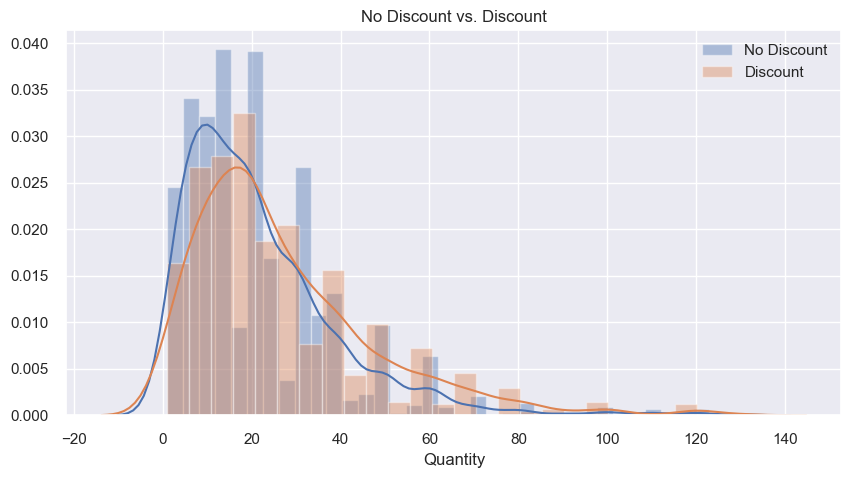

In [9]:
#distribution of quantity for discounted and not discounted product
sns.set(rc={'figure.figsize':(10, 5)})
plt.title("No Discount vs. Discount")
sns.distplot(df_no_disc['Quantity'], label='No Discount') 
sns.distplot(df_discount['Quantity'], label='Discount')
plt.legend()
plt.show();

There does exist a difference in mean quantity values between the two groups. The discounted products are ordered, on average, at quantities of 27, whereas products without applied discounts sell at an average quantity of 22. This alone does not provide sufficient evidence to claim there to be a statistically significant difference, though.
_______________________

Conducting a Welch's T-Test is appropriate in determining if the difference should be considered statistically significant. Other figures will judge the magnitude of the effect. 



In [10]:
# t-value, Welch's T-test, measuring effect size 
results

,Welch's t-test,results
0,Difference (Quantity - Quantity) =,5.3945
1,Degrees of freedom =,1561.7678
2,t =,6.2391
3,Two side test p value =,0.0000
4,Difference > 0 p value =,1.0000
5,Difference < 0 p value =,0.0000
6,Cohen's d =,0.2757
7,Hedge's g =,0.2756
8,Glass's delta =,0.2597
9,r =,0.1559


The P-value(difference < 0 p) and Cohen's D will be the figures primarily used in the hypothesis test results. It also may be worth noting that the average difference in quantity between the groups is 5.39. The other values are derived from different tests, but provide similar enough results.

- To satisfy the rejection of the null hypothesis, the p-value will be below the alpha. 


- Cohen's D will be used to measure the effect size. Cohen's D values range between 0 to 1.

    0= no effect, 1= highest effect

___
The F-Test, or one-way ANOVA, reveals the significance (or lack of significance) of variance among the different levels of discounts and the products without applied discounts.


In [11]:
#One way ANOVA
lm= ols('Quantity ~ C(Discount)', df).fit()
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
C(Discount),21258.403604,10.0,6.011811,4.704231e-09
Residual,758141.232591,2144.0,NaN,NaN


_________________

__Null Hypothesis Rejected:__

   - With the alpha set as 0.01, the P-value indicates the difference in average quantity in discounted product is significantly higher than that in not discounted product.<br>
__(p value: 0.000 < alpha: 0.05)__


- Results from the F-Test/1-way ANOVA are consistent with the above, as the F- statistic is larger than the critical F-Value, and the P-value is significantly below the alpha.<br>
__(f-statistic: 9.7987 > f-critical value: 0.58439)__ <br>

--------------

__Effect Size: small__ 

- While there is a statistically significant difference in the quantities between both groups, the test results show the effect of discount on quantity to be of a low degree.<br>
__Cohen's D = 0.2757 = small effect__ <br>

_*Cohen's D effect sizes have a generally accepted scale("small, d = .2," "medium, d = .5," and "large, d = .8")  The result values for Hedges, Glass's, and R also fall under the "small" effect size using their scales, respectively._




 __With 95% confidence, it is certain that discounted products sold in significantly higher quantities than products held at original prices.__

___

### multiple testing discount rates:
- Do individual discount rates impact the quantity ordered significantly more or less than others?

With there being different discount rates, it's possible that each individual rate causes increase in the quantity sold more or less than the others, or that with increase in discount rate there also runs parallel an increase in quantity sold. Do products given the 25% discount sell more than those at 5%, or does their effect vary independently?

__Null Hypothesis:__

- All discount rates equally impact the quantity ordered.

__Alternative Hypothesis:__

- Quantity of product ordered varies between each level of discount.

__Alpha__ = 0.05

In [12]:
# number of products sold at each discount rate
df.Discount.value_counts()

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

With the 3, 2, 1, 4, and 6 % discount rates having such small sample sizes, they will be excluded from the following hypothesis tests.

In [13]:
# eliminate discount rates providing inadequate sample sizes(n<30)
drop = [0.01, 0.02, 0.03, 0.04, 0.06]
df = df[~df.Discount.isin(drop)]

In [14]:
rp.summary_cont(df['Quantity'].groupby(df['Discount']))

,N,Mean,SD,SE,95% Conf.,Interval
Discount,,,,,,
0.00,1317,21.715262,17.507493,0.482426,20.769347,22.661177
0.05,185,28.010811,22.187685,1.631271,24.804843,31.216779
0.10,173,25.236994,21.186503,1.610780,22.070701,28.403287
0.15,157,28.382166,20.923099,1.669845,25.098796,31.665535
0.20,161,27.024845,18.832801,1.484233,24.106672,29.943017
0.25,154,28.240260,20.120570,1.621362,25.052023,31.428497


- The average quantity per discount group ranges from 21.72 to 28.38, with the highest being at the 15% discount rate, a bit unexpected. These stats alone still don't make clear whether the differences are great enough to take into consideration. 

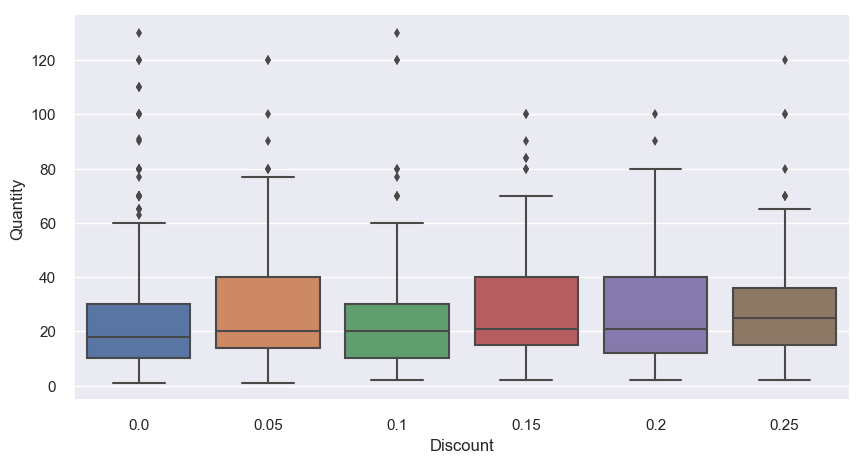

In [15]:
#boxplot discount groups/quantity
sns.set_style('darkgrid')
sns.boxplot(x='Discount', y= 'Quantity', data = df)
sns.despine();

__Some differences between quantity in discount rates can be seen, although not the most visibly dramatic.__

In [16]:
## assigning discount levels to groups
##note to self: replace below with loop?
disc_0 = df[df.Discount == 0.00]
disc_5 = df[df.Discount == 0.05]
disc_10 = df[df.Discount == 0.10]
disc_15 = df[df.Discount == 0.15]
disc_20 = df[df.Discount == 0.20]
disc_25 = df[df.Discount == 0.25]

disc_rates = [disc_5, disc_10, disc_15, disc_20, disc_25]

____
__Exploring the possibility of significant variance between each rate of discount and no discount:__

It may be interesting to look at the P-values and effect sizes of each rate. I'd expect to see all rates result in a P-value under 0.05, but curious which rates have the highest effect sizes.


In [17]:
# Welch's T-tests: each rate vs 0 discount

discounts = ('5%', '10%', '15%', '20%', '25%')

for disc, x in zip( disc_rates, discounts):
    print(x,':')
    descriptives, results = rp.ttest(disc['Quantity'], disc_0['Quantity'], equal_variances=False)
    results

5% :


,Welch's t-test,results
0,Difference (Quantity - Quantity) =,6.2955
1,Degrees of freedom =,217.3603
2,t =,3.7008
3,Two side test p value =,0.0003
4,Difference > 0 p value =,0.9999
5,Difference < 0 p value =,0.0001
6,Cohen's d =,0.2906
7,Hedge's g =,0.2904
8,Glass's delta =,0.2837
9,r =,0.2435


10% :


,Welch's t-test,results
0,Difference (Quantity - Quantity) =,3.5217
1,Degrees of freedom =,204.0260
2,t =,2.0944
3,Two side test p value =,0.0375
4,Difference > 0 p value =,0.9813
5,Difference < 0 p value =,0.0187
6,Cohen's d =,0.1694
7,Hedge's g =,0.1693
8,Glass's delta =,0.1662
9,r =,0.1451


15% :


,Welch's t-test,results
0,Difference (Quantity - Quantity) =,6.6669
1,Degrees of freedom =,182.9771
2,t =,3.8357
3,Two side test p value =,0.0002
4,Difference > 0 p value =,0.9999
5,Difference < 0 p value =,0.0001
6,Cohen's d =,0.3239
7,Hedge's g =,0.3237
8,Glass's delta =,0.3186
9,r =,0.2728


20% :


,Welch's t-test,results
0,Difference (Quantity - Quantity) =,5.3096
1,Degrees of freedom =,195.3279
2,t =,3.4021
3,Two side test p value =,0.0008
4,Difference > 0 p value =,0.9996
5,Difference < 0 p value =,0.0004
6,Cohen's d =,0.2840
7,Hedge's g =,0.2839
8,Glass's delta =,0.2819
9,r =,0.2365


25% :


,Welch's t-test,results
0,Difference (Quantity - Quantity) =,6.5250
1,Degrees of freedom =,181.1251
2,t =,3.8573
3,Two side test p value =,0.0002
4,Difference > 0 p value =,0.9999
5,Difference < 0 p value =,0.0001
6,Cohen's d =,0.3285
7,Hedge's g =,0.3283
8,Glass's delta =,0.3243
9,r =,0.2755


All resulting P-values were below the alpha.<br>


- It had previously been established that all discounted products as a whole, sold in higher quantities than regularly priced products, but the above tests confirm that the alternative hypothesis applies to each individual rate of discount as well. 


- There were some slight differences in effect sizes. The effect size of the 10% discount is the least significant, and 25% the most. All others share a small effect size. 

   _Cohen's D:_
    - 05% = .2906
    - 10% = .1694
    - 15% = .3239
    - 20% = .2840
    - 25% = .3285



____
__Multicomparison test__

Tukey's Multicomparison Test will show if significant variance exists between each permutation of discount rates.<br>

_* For each permutation, the null hypothesis being there is no variance, the alternative being there is significant variance, <br>alpha = 0.05_

In [18]:
mc = statsmodels.stats.multicomp.MultiComparison(df['Quantity'], df['Discount'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
 0.0    0.05   6.2955   2.0814 10.5097  True 
 0.0    0.1    3.5217  -0.8187  7.8622 False 
 0.0    0.15   6.6669   2.1352 11.1986  True 
 0.0    0.2    5.3096   0.8285  9.7907  True 
 0.0    0.25   6.525    1.954   11.096  True 
 0.05   0.1   -2.7738  -8.4504  2.9028 False 
 0.05   0.15   0.3714  -5.4528  6.1955 False 
 0.05   0.2    -0.986  -6.7708  4.7989 False 
 0.05   0.25   0.2294  -5.6253  6.0842 False 
 0.1    0.15   3.1452   -2.771  9.0613 False 
 0.1    0.2    1.7879  -4.0896  7.6653 False 
 0.1    0.25   3.0033   -2.943  8.9496 False 
 0.15   0.2   -1.3573  -7.3775  4.6628 False 
 0.15   0.25  -0.1419  -6.2292  5.9454 False 
 0.2    0.25   1.2154  -4.8343  7.2652 False 
---------------------------------------------


- The results of Tukey's tests suggest that applying a product discount of 5, 15, 20, or 25 percent encourages customers to order products in higher quantities, just as had been observed in the T-Tests. Considering also the Cohen's D, 15% and 25% discounts may be the most effective.

_____
The above tests have given evidence that some discount rates are more effective at increasing sale quantities than others, when comparing each level of discount to quantities of products ordered without discounts. 

However, the below F-test will judge the variance of quantity amongst the levels of discounts altogether, without the not discounted products in the comparison:

In [19]:
stats.f_oneway(disc_5['Quantity']
               , disc_10['Quantity']
               , disc_15['Quantity']
               , disc_20['Quantity']
               , disc_25['Quantity'])

F_onewayResult(statistic=0.6741032559876151, pvalue=0.610041445360832)

__Fail to reject null hypothesis__ <br>

Variance between each level of discount is not confirmed in the results of the above F-test.<br>
P-value exceeds the alpha. <br>
__0.61 > 0.05__

__________________


__There is insufficient evidence to conclude that the different discount rates significantly impact the quantity of product ordered more or less than other discount rates.__

- Overall, you could still expect a discount at any rate to increase the sale of product, but effect size was greatest with the 15% and 25% discounts. With the implication that these discount rates most effectively encourage the sale in product, it may be in best interest to apply to products nearing the expiration date, are overstocked, past season, or have some other urgent motivation to sell. 

____

## Hypothesis 2 (discount/profit)



__Null Hypothesis :__
- All products generate equal proceeds, regardless of any applied discounts.

__Alternative Hypothesis:__
- Applying discounts result in higher proceeds per discounted product.

__Alpha__ = 0.05

 Even with confidence that applying discounts results in increasing the product sales in quantity, there may some hesitation when factoring in the potential loss of profit involved. One would hope, with increasing the quantity of product sold, there's also a significant increase in profit regardless of the amount discounted. 

In [20]:
#selecting discount/profit data
c.execute("""SELECT 'Order'.Id, Discount, OrderDetail.UnitPrice, Quantity
            FROM OrderDetail
            JOIN 'Order'
            ON 'Order'.Id = OrderDetail.OrderId
            INNER JOIN Product
            ON Product.Id = OrderDetail.ProductId
            WHERE Discount != 0.06 AND Discount > 0.04 OR Discount = 0.00
             ;""")
df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]
df.head()

,Id,Discount,UnitPrice,Quantity
0,10248,0.0,14.0,12
1,10248,0.0,9.8,10
2,10248,0.0,34.8,5
3,10249,0.0,18.6,9
4,10249,0.0,42.4,40


In [21]:
#creating 'total' column
df['Total']= df['UnitPrice']* df['Quantity']

In [22]:
#assigning groups to discount rates
yes_disc = df[df.Discount !=0.0]
no_disc = df[df.Discount == 0.00]

disc_0 = df[df.Discount == 0.00]
disc_5 = df[df.Discount == 0.05]
disc_10 = df[df.Discount == 0.10]
disc_15 = df[df.Discount == 0.15]
disc_20 = df[df.Discount == 0.20]
disc_25 = df[df.Discount == 0.25]

disc_rates = [disc_5, disc_10, disc_15, disc_20, disc_25]

### Testing between 2 groups
- Does applying discounts to products result in higher revenue?

In [23]:
descriptives, results = rp.ttest(yes_disc['Total'], no_disc['Total'], equal_variances=False)
descriptives

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Total,830.0,726.982325,1142.650416,39.661975,649.132623,804.832028
1,Total,1317.0,570.006538,961.375030,26.491097,518.037144,621.975932
2,combined,2147.0,630.691169,1037.783860,22.397054,586.768978,674.613360


Discounted products, on average, do bring in more profit than not discounted products. These averages are based on the total spent on the total amount of the product per order.


Discounted  = $727

Not Discounted  = $570

_____________

__Performing Welch's T Test:__

In [24]:
results

,Welch's t-test,results
0,Difference (Total - Total) =,156.9758
1,Degrees of freedom =,1540.5179
2,t =,3.2912
3,Two side test p value =,0.0010
4,Difference > 0 p value =,0.9995
5,Difference < 0 p value =,0.0005
6,Cohen's d =,0.1459
7,Hedge's g =,0.1458
8,Glass's delta =,0.1374
9,r =,0.0836


__Calculating f-critical value and performing F- test:__

In [25]:
lm= ols('Total ~ C(Discount)', df).fit()
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
C(Discount),2.184121e+07,5.0,4.085107,0.001077
Residual,2.289391e+09,2141.0,NaN,NaN


________________

__- Null Hypothesis Rejected__

P value = 0.001 < Alpha = 0.05


__- Effect size = below small__



Both T and F test support the rejection of the Null Hypothesis, but the effect size is found to be insignificant.

While there is a significant difference in profit made from discounted products and not discounted products, the effect isn't overwhelming. 

___

### Multiple testing 

- Does profit vary between products with different discount rates?

Perhaps more profit is made from the products given one of the lower discount rates. You might expect the products with a 25% discount to have a lower return than the discount rates taking less of a cut off from the original product price.

In [26]:
df.groupby(['Discount']).mean()

,Id,UnitPrice,Quantity,Total
Discount,,,,
0.00,10662.791951,26.171534,21.715262,570.006538
0.05,10661.713514,30.796324,28.010811,839.928162
0.10,10598.398844,25.171561,25.236994,587.663064
0.15,10656.025478,22.975924,28.382166,655.722548
0.20,10631.708075,23.526770,27.024845,692.399876
0.25,10706.500000,28.214416,28.240260,856.610974


- Products given a 25% and 5% discount account for the highest revenue(839, 856).

*_The average product price in those discount rates are also highest among the other groups (31, 28), which may mean that certain types of product that are typically also higher priced, are receiving these discount rates and would explain the higher revenue._
___

Welch's T tests for product totals in each discount rate group:

In [27]:
discounts = ('5%', '10%', '15%', '20%', '25%')

for disc, x in zip( disc_rates, discounts):
    print(x,':')
    descriptives, results = rp.ttest(disc['Total'], no_disc['Total'], equal_variances=False)
    results

5% :


,Welch's t-test,results
0,Difference (Total - Total) =,269.9216
1,Degrees of freedom =,205.3545
2,t =,2.3597
3,Two side test p value =,0.0192
4,Difference > 0 p value =,0.9904
5,Difference < 0 p value =,0.0096
6,Cohen's d =,0.1853
7,Hedge's g =,0.1852
8,Glass's delta =,0.1783
9,r =,0.1625


10% :


,Welch's t-test,results
0,Difference (Total - Total) =,17.6565
1,Degrees of freedom =,283.8423
2,t =,0.3168
3,Two side test p value =,0.7517
4,Difference > 0 p value =,0.6242
5,Difference < 0 p value =,0.3758
6,Cohen's d =,0.0256
7,Hedge's g =,0.0256
8,Glass's delta =,0.0274
9,r =,0.0188


15% :


,Welch's t-test,results
0,Difference (Total - Total) =,85.7160
1,Degrees of freedom =,237.0618
2,t =,1.4159
3,Two side test p value =,0.1581
4,Difference > 0 p value =,0.9209
5,Difference < 0 p value =,0.0791
6,Cohen's d =,0.1195
7,Hedge's g =,0.1195
8,Glass's delta =,0.1257
9,r =,0.0916


20% :


,Welch's t-test,results
0,Difference (Total - Total) =,122.3933
1,Degrees of freedom =,184.9443
2,t =,1.2241
3,Two side test p value =,0.2225
4,Difference > 0 p value =,0.8888
5,Difference < 0 p value =,0.1112
6,Cohen's d =,0.1022
7,Hedge's g =,0.1022
8,Glass's delta =,0.1001
9,r =,0.0897


25% :


,Welch's t-test,results
0,Difference (Total - Total) =,286.6044
1,Degrees of freedom =,172.3872
2,t =,2.6082
3,Two side test p value =,0.0099
4,Difference > 0 p value =,0.9950
5,Difference < 0 p value =,0.0050
6,Cohen's d =,0.2221
7,Hedge's g =,0.2220
8,Glass's delta =,0.2166
9,r =,0.1948


- The Welch's T test shows a significant difference in profit between each discount rate(except for 10%), and no discount.


- The 25% discount rate has the highest effect size, at .2221, though still a small effect, impressive considering it's the largest of the discount rates.  <br>


__Tukey's MultiComparison Test:__


In [28]:
mc = statsmodels.stats.multicomp.MultiComparison(df['Total'], df['Discount'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2  meandiff   lower    upper   reject
-------------------------------------------------
 0.0    0.05   269.9216  38.3437  501.4995  True 
 0.0    0.1    17.6565  -220.8598 256.1728 False 
 0.0    0.15    85.716  -163.3113 334.7433 False 
 0.0    0.2    122.3933 -123.8544 368.6411 False 
 0.0    0.25   286.6044  35.4193  537.7896  True 
 0.05   0.1   -252.2651 -564.2068 59.6766  False 
 0.05   0.15  -184.2056 -504.2559 135.8447 False 
 0.05   0.2   -147.5283 -465.4207 170.3641 False 
 0.05   0.25   16.6828  -305.0494 338.415  False 
 0.1    0.15   68.0595  -257.0465 393.1655 False 
 0.1    0.2    104.7368 -218.2451 427.7187 False 
 0.1    0.25   268.9479  -57.814  595.7098 False 
 0.15   0.2    36.6773  -294.1426 367.4973 False 
 0.15   0.25   200.8884  -133.623 535.3998 False 
 0.2    0.25   164.2111 -168.2363 496.6584 False 
-------------------------------------------------


The Tukey test once again confirm that products with 5% and 25% discount rates consistently appear to have some effect on product revenue. <br>
___

__F-Test:__
Does profit vary significantly between the discount rates?

In [29]:
#F-test - variance between 5, 10, 15, 20, 25% 
stats.f_oneway(disc_5['Total']
               , disc_10['Total']
               , disc_15['Total']
               , disc_20['Total']
               , disc_25['Total'])

F_onewayResult(statistic=1.786605404580769, pvalue=0.12946553513611003)

__Results:__

- Results from the t-tests and Tukey's multiple comparison test indicate a statistically significant difference in product revenue between product without discount and products at a 5 or 25% discount. The 25% discount rate was the only rate with a Cohen's D effect size over .2(small effect). The 5% discount rate wasn't far behind, though, at .19.



- Generally, there is no significant variance in product revenue found among the different discount rates.

    __p-value = 0.129 > alpha = 0.05__

Further exploration may reveal that the differences in revenue are due to the higher original prices of the products those discounts rates were applied to. But with the 5% and 25% being the most effective, the 5% probably feels like a more comfortable discount rate to apply with expectations of increasing revenue.
______

## Hypothesis 3 (discount/ order total) 

__Null Hypothesis__:
- Order totals are equivalent in orders including and excluding discounted items.

__Alternative Hypothesis__:
- Order totals are higher when customer has included at least one discounted item.

__Alpha__: 0.05


Previously, the focus was on how the discounts may have impacted the quantity or profits of the product it was applied to, and there was significant impact found. With those results, should it be safe to say that discounted products also make a significant impact in the total amount of the customers' orders? I'm curious as to if orders including at least one discounted product have higher totals than orders containing exclusively non-discounted products.

In [30]:
#selecting data
c.execute("""SELECT 'Order'.Id, Discount, OrderDetail.UnitPrice, Quantity
            FROM OrderDetail
            JOIN 'Order'
            ON 'Order'.Id = OrderDetail.OrderId
            INNER JOIN Product
            ON Product.Id = OrderDetail.ProductId
            WHERE Discount != 0.06 AND Discount > 0.04 OR Discount = 0.00
             ;""")
df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]
df.head()

,Id,Discount,UnitPrice,Quantity
0,10248,0.0,14.0,12
1,10248,0.0,9.8,10
2,10248,0.0,34.8,5
3,10249,0.0,18.6,9
4,10249,0.0,42.4,40


### T-testing
- Do customers spend more on their orders when they've included at least one discounted product?

In [31]:
df['Total']= df['UnitPrice']* df['Quantity']
df = df.groupby(['Id'], as_index=False).sum()
df.head()

,Id,Discount,UnitPrice,Quantity,Total
0,10248,0.0,58.6,27,440.0
1,10249,0.0,61.0,49,1863.4
2,10250,0.3,66.9,60,1813.0
3,10251,0.1,49.2,41,670.8
4,10252,0.1,94.0,105,3730.0


In [32]:
included_disc = df[df.Discount > 0]
without_disc = df[df.Discount == 0]

In [33]:
descriptives, results= rp.ttest(included_disc['Total'], without_disc['Total'], equal_variances = False)
descriptives

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Total,380.0,1934.722658,2165.747840,111.100520,1716.272041,2153.173275
1,Total,450.0,1375.331844,1792.781223,84.512517,1209.242651,1541.421038
2,combined,830.0,1631.438482,1990.711052,69.098589,1495.809718,1767.067245


In [34]:
results

,Welch's t-test,results
0,Difference (Total - Total) =,559.3908
1,Degrees of freedom =,736.3873
2,t =,4.0074
3,Two side test p value =,0.0001
4,Difference > 0 p value =,1.0000
5,Difference < 0 p value =,0.0000
6,Cohen's d =,0.2792
7,Hedge's g =,0.2789
8,Glass's delta =,0.2583
9,r =,0.1461


__Null Hypothesis rejected__

Customers spend more on their total orders when they've included at least one discounted product.

      P-value = 0.000 < alpha = 0.05
      
__Effect size = small__

    Cohen's D = 0.2792
____


__Customers ordering discounted products do have significantly higher order totals, on average, than orders containing exclusively non-discounted product.__ 

In [35]:
#ignore
# #creating anova table with additional values for effect size
# def anova_table(aov):
#     aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
#     aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
#     aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
#     cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
#     aov = aov[cols]
#     return aov
# anova_table(aov_table)

## Hypothesis 3 (shippers/shiptime)

Something of interest to the Northwind Traders company might be the amount of time shipping companies take to deliver orders. In the dataset given, the date of order placed, date of shipment, and date customer requires the order, are provided. There may be some orders delivered past the required date, but seeing that happen in excess with a particular shipping company would be an issue that may be worth addressing. Consumers, in general, prefer to have their product delivered with urgency. Some large companies even charge a fee to be a member with fast delivery being a valued perk. So I think it's fair to speculate that customers of NorthWind Traders would value speedy shipping just the same, and it may be something that could later be used to increase revenue or encourage loyal customers.

__Null Hypothesis:__
- All shippers deliver products in the same timely manner.

__Alternative Hypothesis:__
- Some shippers deliver orders faster than others.

__Alpha = .05__

_*further tests to include the region, product category, and other potentially influential features_

In [36]:
#selecting data
c.execute("""SELECT Shipper.CompanyName, ShippedDate, ShipVia, OrderDate, RequiredDate, Freight, ShipRegion, Customer.Region
FROM 'Order'
INNER JOIN Customer on 'Order'.CustomerId = Customer.Id
JOIN Shipper ON ShipVia = Shipper.Id
             ;""")
df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]
df.head()

,CompanyName,ShippedDate,ShipVia,OrderDate,RequiredDate,Freight,ShipRegion,Region
0,Federal Shipping,2012-07-16,3,2012-07-04,2012-08-01,32.38,Western Europe,Western Europe
1,Speedy Express,2012-07-10,1,2012-07-05,2012-08-16,11.61,Western Europe,Western Europe
2,United Package,2012-07-12,2,2012-07-08,2012-08-05,65.83,South America,South America
3,Speedy Express,2012-07-15,1,2012-07-08,2012-08-05,41.34,Western Europe,Western Europe
4,United Package,2012-07-11,2,2012-07-09,2012-08-06,51.30,Western Europe,Western Europe


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 8 columns):
CompanyName     801 non-null object
ShippedDate     781 non-null object
ShipVia         801 non-null int64
OrderDate       801 non-null object
RequiredDate    801 non-null object
Freight         801 non-null float64
ShipRegion      801 non-null object
Region          801 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 50.1+ KB


In [38]:
pandas_profiling.ProfileReport(df)

Number of variables,8
Number of observations,801
Total Missing (%),0.3%
Total size in memory,50.1 KiB
Average record size in memory,64.1 B
Numeric,2
Categorical,6
Boolean,0
Date,0
Text (Unique),0
Rejected,0


The orders are evenly enough distributed between the companies, with each company delivering between 236-313 orders. Of 9 regions, Western Europe, North and South America, and British Isles make up for around 80% of total orders. The others are Southern and Northern Europe, Scandinavia, Central America, and Eastern Europe.

In [39]:
#shipped date has 21 null values(2.5% of data), which will be excluded from testing
df = df.dropna()

In [40]:
#convert data to usable format
df['ShippedDate']= pd.to_datetime(df['ShippedDate'])
df['OrderDate'] = pd.to_datetime(df['OrderDate'])
df['RequiredDate'] = pd.to_datetime(df['RequiredDate'])

#creating ShipTime column for amount of days the shipper took to deliver
df['ShipTime'] = (df['ShippedDate'] - df['OrderDate']).dt.days

#OnTime column for count of days delivered before or after required date
df['OnTime'] = (df['RequiredDate'] - df['ShippedDate']).dt.days
df['Late'] = (df['OnTime'] < 0)

In [41]:
df.ShipTime.describe()

count    781.000000
mean       8.510883
std        6.876302
min        1.000000
25%        4.000000
50%        7.000000
75%        9.000000
max       37.000000
Name: ShipTime, dtype: float64

- Shipping times usually fall between 4-9 days, but there's also been orders delivered as early as one day, and as late as 37 days. 

In [42]:
#how many orders have been delivered after the required date?
len(df)
print ('orders on time:', len(df[df.OnTime >= 0]))
print('orders late:',len(df[df.OnTime <0]))
df.groupby(['CompanyName'])['Late'].sum()

781

orders on time: 744
orders late: 37


CompanyName
Federal Shipping     9.0
Speedy Express      12.0
United Package      16.0
Name: Late, dtype: float64

- Overall there were 37 late shipments(roughly 5% of total orders), and the United Package shipping company accounts for the most late shipments. 

In [43]:
df.groupby(['CompanyName']).mean()

,ShipVia,Freight,ShipTime,OnTime,Late
CompanyName,,,,,
Federal Shipping,3.0,82.315203,7.520325,19.967480,0.036585
Speedy Express,1.0,66.005474,8.625000,19.375000,0.051724
United Package,2.0,85.321452,9.227723,18.772277,0.052805


- __Federal Shipping has the lowest average ship time, being 7.47 days. They also have the lowest average late shipments__ <br>

_*It comes to me as surprising that the shipper with the highest average freight cost also has the highest average ship time. This may be worth exploring as well._
___

__Tukey's test: how do the different companies' shipping times compare to one another?__


In [44]:
mc = statsmodels.stats.multicomp.MultiComparison(df['ShipTime'], df['CompanyName'])
mc_results = mc.tukeyhsd()
print(mc_results)

      Multiple Comparison of Means - Tukey HSD,FWER=0.05      
     group1          group2     meandiff  lower  upper  reject
--------------------------------------------------------------
Federal Shipping Speedy Express  1.1047  -0.3669 2.5763 False 
Federal Shipping United Package  1.7074   0.3274 3.0874  True 
 Speedy Express  United Package  0.6027  -0.8001 2.0055 False 
--------------------------------------------------------------


- United Package takes significantly longer(1.7 days) to ship orders than Federal Shipping.

__ANOVA__<br>
Is a variance of less than two days ship time between the three companies enough to be considered statistically significant? 

In [45]:
lm= ols('ShipTime ~ C(CompanyName)', df).fit()
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
C(CompanyName),400.096988,2.0,4.266261,0.014364
Residual,36481.060503,778.0,NaN,NaN


__Null Hypothesis Rejected__

- P-value = 0.00956 < alpha = 0.05

__The variance between average ship times of Shipping Companies is statistically significant.__ <br>

* Federal Shipping has the fastest shipping timing, and the least late shipments, on average.

Not enough data was explored to make a fair judgment on the performance of the shippers. Factors that may play a big part in the variance could also be the type of product being shipped, the distance between supplier to customer, and the shipping costs .
___


### Variance between Shippers/ Freight costs:

- What could be causing the difference in ship times? It's possible that shippers offer expedited shipping to customers with extra fees, resulting in higher shipping costs?

__Tukey's Multicomparison testing variance of Freight costs:__

In [46]:
mc = statsmodels.stats.multicomp.MultiComparison(df['Freight'], df['CompanyName'])
mc_results = mc.tukeyhsd()
print(mc_results)

       Multiple Comparison of Means - Tukey HSD,FWER=0.05       
     group1          group2     meandiff  lower    upper  reject
----------------------------------------------------------------
Federal Shipping Speedy Express -16.3097 -41.1438  8.5244 False 
Federal Shipping United Package  3.0062  -20.2824 26.2949 False 
 Speedy Express  United Package  19.316  -4.3573  42.9892 False 
----------------------------------------------------------------


In [47]:
lm= ols('Freight ~ C(ShipVia)', df).fit()
sm.stats.anova_lm(lm, typ=2)

,sum_sq,df,F,PR(>F)
C(ShipVia),5.388366e+04,2.0,2.017561,0.133675
Residual,1.038915e+07,778.0,NaN,NaN


Conclusion:


__Judging from the Tukey and F-Test, the freight cost doesn't significantly vary between Shippers.__

The ship time varies significantly between the three companies, but not the freight costs. I would think most would associate higher shipping costs with faster shipping. 

__* The tests conducted were only comparing the averages between the three companies, and not the average costs per order, so it's not to say the shippers individually don't offer expedited shipping at higher costs, as there may be seen more variance between shipping costs within each company.__
______

### Shippers /Product Category or Region (visuals only)
- Could the variance in ship time be due to the type of product or the area it's being shipped from/to?

With there being significant variance among the shipping companies' ship times, I wanted to explore possible explanations for this. One thought is that some shippers' performance was limited because of the type of product they're delivering. Northwest Traders carries 8 different categories of product: beverages, condiments, confections, dairy, grains/cereals, meat/poultry, produce, and seafood. Many of those items likely require refrigeration, or require special handling that may need to be delivered in specialized vehicles, or handled in a way not all shipping companies had the resources to accommodate. If certain companies showed favor with certain product categories, it could warrant further exploration. 

In [48]:
#selecting data
c.execute("""SELECT CategoryId, ShipVia, CategoryName, Supplier.Region
FROM Product
JOIN OrderDetail
ON Product.Id = OrderDetail.ProductId
JOIN 'Order'
ON 'Order'.Id = OrderDetail.OrderId
JOIN Category
ON Product.CategoryId = Category.Id
JOIN Supplier
ON Product.SupplierId = Supplier.Id
             ;""")
df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]
df.head()

,CategoryId,ShipVia,CategoryName,Region
0,4,3,Dairy Products,Southern Europe
1,5,3,Grains/Cereals,South-East Asia
2,4,3,Dairy Products,Southern Europe
3,7,1,Produce,Eastern Asia
4,7,1,Produce,NSW


In [49]:
# df.CategoryId.value_counts()
# df.ShipVia.value_counts()

Do shippers prefer certain product categories?

The figure below explores the distribution of product deliveries among shipping companies in regards to categories.

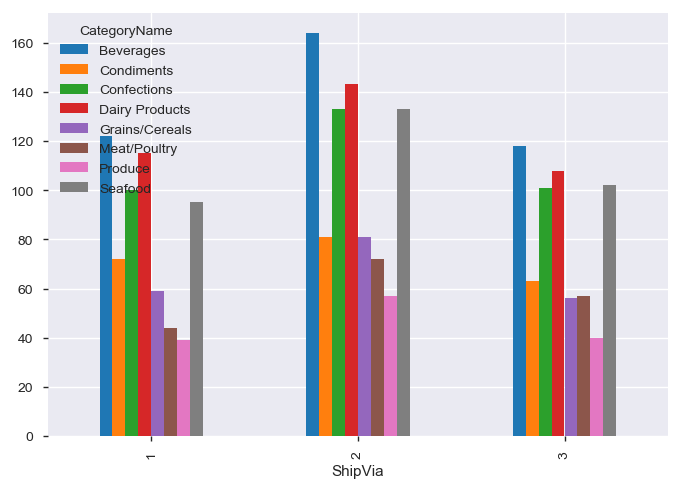

In [50]:
#quantity of products delivered from each category, for each shipper
df.groupby(['ShipVia'])['CategoryName'].value_counts().unstack().plot.bar();

- All shipping companies appear to deliver products in each category similarly. 

______
Another thought is that the region the products are being shipped from has some effect. The variance in climate or other geographical conditions may vary in regions to the extent of causing delays in the delivery times.


Do certain shipping companies primarily service particular regions more or less so than the others? 

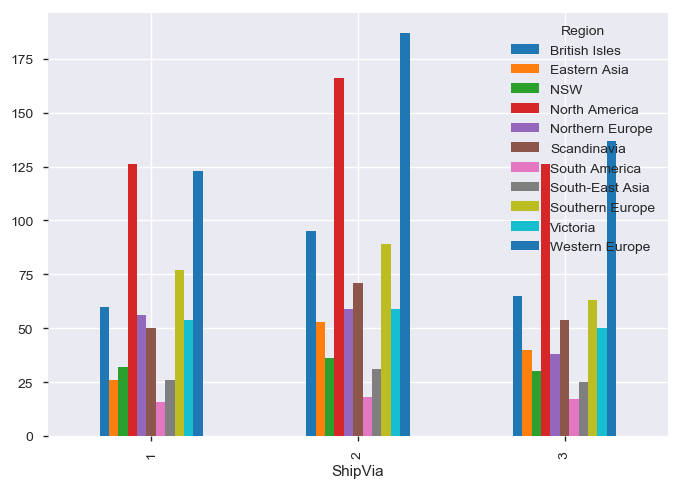

In [51]:
#quantity of products delivered from each region, by shipper
df.groupby(['ShipVia'])['Region'].value_counts().unstack().plot.bar();

- Once again, no major differences can be assumed from the above visual. It seems the companies all ship product from each region fairly equally.

__There doesn't appear to be great differences in products delivered by category, or by Region from each Shipper, but testing the data further, considering additional variables, would be a more useful source from which to draw conclusions.__

## Hypothesis 5: (Employees/ sales)
* Do individual employees perform significantly better or worse than average?

Northwind Traders have employed 9 employees, and although there are 4 different titles, each employee has been involved in the sales of product, with each order having an employees' name attached. 

The employees all have degrees of some sort, with varied backgrounds


The length of employment and title won't be of interest in the below hypothesis tests, but could prove to be valuable information with future analysis. 

__Null Hypothesis:__
- The average total order prices are equal among all employees.

__Alternative Hypothesis:__
- Some employees perform significantly better or worse than others.


__Alpha = 0.05__

In [52]:
#selecting data
c.execute("""SELECT  Title,'Order'.Id, OrderDetail.UnitPrice, Quantity, FirstName, LastName, BirthDate, OrderDate
            FROM OrderDetail
            JOIN 'Order'
            ON 'Order'.Id = OrderDetail.OrderId
            JOIN Employee
            ON Employee.Id = 'Order'.EmployeeId
             ;""")
df = pd.DataFrame(c.fetchall())
df.columns = [x[0] for x in c.description]
df.head()

,Title,Id,UnitPrice,Quantity,FirstName,LastName,BirthDate,OrderDate
0,Sales Manager,10248,14.0,12,Steven,Buchanan,1987-03-04,2012-07-04
1,Sales Manager,10248,9.8,10,Steven,Buchanan,1987-03-04,2012-07-04
2,Sales Manager,10248,34.8,5,Steven,Buchanan,1987-03-04,2012-07-04
3,Sales Representative,10249,18.6,9,Michael,Suyama,1995-07-02,2012-07-05
4,Sales Representative,10249,42.4,40,Michael,Suyama,1995-07-02,2012-07-05


In [53]:
#Return to at a later time - figuring out hiredate issues & age
# I was trying to figure out why the Hire Dates were in the future, with no luck

# #subtracting 10 years should correct this, but it would need to be confirmed
# df['HireDate']= pd.to_datetime(df['HireDate'])
# df['HireDate'] = pd.to_datetime(df['HireDate'].apply(lambda x: x - pd.DateOffset(years=15)))
# df.head()

# #using the last order date as reference to determine age of employee at time of order
# df['OrderDate'] = pd.to_datetime(df['OrderDate'])
# df['BirthDate'] = pd.to_datetime(df['BirthDate'])

# #calculating age(in days)
# df['Age'] = ((df['OrderDate'])- (df['BirthDate'])).dt.days

In [54]:
#using the last order date as reference to determine age of employee at time of order
df['OrderDate'] = pd.to_datetime(df['OrderDate'])
df['BirthDate'] = pd.to_datetime(df['BirthDate'])

## maybe later check for correlation between age at time of order and order total?

#calculating age(in days) 
#df['Age'] = ((df['OrderDate'])- (df['BirthDate'])).dt.days

In [55]:
#assigning Total column
df['Total']= df['UnitPrice']* df['Quantity']

In [56]:
# grouping individual product orders with their overall orderId for true total
df= df.groupby(['Id', 'FirstName'], as_index = False).sum()
#df.head()

In [57]:
df.groupby(['FirstName'], as_index = False).mean()

,FirstName,Id,UnitPrice,Quantity,Total
0,Andrew,10706.989583,72.014687,63.072917,1851.554792
1,Anne,10725.418605,78.609302,62.093023,1929.395349
2,Janet,10662.622047,68.885197,61.826772,1677.569291
3,Laura,10642.240385,59.992788,56.855769,1281.740673
4,Margaret,10638.903846,71.713397,62.807692,1603.765705
5,Michael,10643.835821,57.238209,52.641791,1167.135821
6,Nancy,10670.016260,70.995447,63.512195,1643.444797
7,Robert,10672.361111,65.520972,64.638889,1962.444306
8,Steven,10624.690476,65.415000,72.285714,1799.232143


In [58]:
import pandas_profiling
pandas_profiling.ProfileReport(df)

Number of variables,5
Number of observations,830
Total Missing (%),0.0%
Total size in memory,38.9 KiB
Average record size in memory,48.0 B
Numeric,4
Categorical,1
Boolean,0
Date,0
Text (Unique),0
Rejected,0


With 9 employees, and between the course of 2 years(July 2012 to May 2014), 830 orders have been placed. Each employee accounts for between 42 to 156 orders.The variance between the number of orders per employee may correlate with the amount of time each has been employed with Northwind and could also play into the strength of their performance. Other factors influencing their performance could be the amount of experience they've had in the grocery business or in sales, generally speaking. For now, the focus will be on the average amount in profit of the total order per employee.

In [59]:
#assigning employees to dfs
Steven = df[df.FirstName == 'Steven']
Michael = df[df.FirstName == 'Michael']
Margaret = df[df.FirstName == 'Margaret']
Janet = df[df.FirstName == 'Janet']
Anne = df[df.FirstName == 'Anne']
Nancy = df[df.FirstName == 'Nancy']
Laura = df[df.FirstName == 'Laura']
Andrew = df[df.FirstName == 'Andrew']
Robert = df[df.FirstName == 'Robert']

names = [Steven, Michael, Margaret, Janet, Anne, Nancy, Laura,
       Andrew, Robert]

______
__T-testing the different employees' Order Totals against average__ <br>
- Do any employees perform significantly higher or lower than company average, and if so, to what effect?

The Welch's T tests will be done between each Employee individually and the full dataset of employees altogether. The results will provide a measure of how significant the employees' average orders amount to when compared to the company average.

In [60]:
for name, x in zip(names, df.FirstName.unique()):
    print(x,':')
    descriptives, results = rp.ttest(name['Total'], df['Total'], equal_variances=False)
    results

Steven :


,Welch's t-test,results
0,Difference (Total - Total) =,167.3543
1,Degrees of freedom =,44.5213
2,t =,0.4868
3,Two side test p value =,0.6288
4,Difference > 0 p value =,0.6856
5,Difference < 0 p value =,0.3144
6,Cohen's d =,0.0770
7,Hedge's g =,0.0769
8,Glass's delta =,0.0767
9,r =,0.0728


Michael :


,Welch's t-test,results
0,Difference (Total - Total) =,-464.7420
1,Degrees of freedom =,112.9305
2,t =,-3.2847
3,Two side test p value =,0.0014
4,Difference > 0 p value =,0.0007
5,Difference < 0 p value =,0.9993
6,Cohen's d =,-0.4172
7,Hedge's g =,-0.4168
8,Glass's delta =,-0.4599
9,r =,0.2953


Margaret :


,Welch's t-test,results
0,Difference (Total - Total) =,-28.1121
1,Degrees of freedom =,242.7144
2,t =,-0.1846
3,Two side test p value =,0.8537
4,Difference > 0 p value =,0.4269
5,Difference < 0 p value =,0.5731
6,Cohen's d =,-0.0161
7,Hedge's g =,-0.0161
8,Glass's delta =,-0.0166
9,r =,0.0118


Janet :


,Welch's t-test,results
0,Difference (Total - Total) =,45.6915
1,Degrees of freedom =,161.5913
2,t =,0.2273
3,Two side test p value =,0.8205
4,Difference > 0 p value =,0.5898
5,Difference < 0 p value =,0.4102
6,Cohen's d =,0.0217
7,Hedge's g =,0.0216
8,Glass's delta =,0.0215
9,r =,0.0179


Anne :


,Welch's t-test,results
0,Difference (Total - Total) =,297.5175
1,Degrees of freedom =,45.1622
2,t =,0.8133
3,Two side test p value =,0.4203
4,Difference > 0 p value =,0.7899
5,Difference < 0 p value =,0.2101
6,Cohen's d =,0.1272
7,Hedge's g =,0.1271
8,Glass's delta =,0.1263
9,r =,0.1201


Nancy :


,Welch's t-test,results
0,Difference (Total - Total) =,11.5670
1,Degrees of freedom =,166.5620
2,t =,0.0640
3,Two side test p value =,0.9491
4,Difference > 0 p value =,0.5255
5,Difference < 0 p value =,0.4745
6,Cohen's d =,0.0062
7,Hedge's g =,0.0062
8,Glass's delta =,0.0062
9,r =,0.0050


Laura :


,Welch's t-test,results
0,Difference (Total - Total) =,-350.1371
1,Degrees of freedom =,203.2727
2,t =,-2.7563
3,Two side test p value =,0.0064
4,Difference > 0 p value =,0.0032
5,Difference < 0 p value =,0.9968
6,Cohen's d =,-0.2867
7,Hedge's g =,-0.2865
8,Glass's delta =,-0.3221
9,r =,0.1898


Andrew :


,Welch's t-test,results
0,Difference (Total - Total) =,219.6770
1,Degrees of freedom =,108.5759
2,t =,0.8097
3,Two side test p value =,0.4199
4,Difference > 0 p value =,0.7901
5,Difference < 0 p value =,0.2099
6,Cohen's d =,0.0873
7,Hedge's g =,0.0872
8,Glass's delta =,0.0855
9,r =,0.0775


Robert :


,Welch's t-test,results
0,Difference (Total - Total) =,330.5665
1,Degrees of freedom =,77.3091
2,t =,0.9776
3,Two side test p value =,0.3313
4,Difference > 0 p value =,0.8343
5,Difference < 0 p value =,0.1657
6,Cohen's d =,0.1201
7,Hedge's g =,0.1200
8,Glass's delta =,0.1177
9,r =,0.1105


Employees whose Order Totals, on average, significantly deviate from average:


   
__Michael:__<br> 
$464 below below order total <br>
Cohen's D effect size = -0.4172(medium)<br>
    
__Laura:__
<br>$350 below average order total<br>
Cohen's D effect size = -0.2867(small)<br>




_No employees' Order Totals were found to be significantly above average Order Total_
    
    

_________
__ANOVA:__
<br> Do the average order totals significantly vary between the employees?

In [61]:
results = ols('Total ~ C(FirstName)', data=df).fit()
sm.stats.anova_lm(results, typ=2)

,sum_sq,df,F,PR(>F)
C(FirstName),4.510891e+07,8.0,1.428867,0.180385
Residual,3.239840e+09,821.0,NaN,NaN


__Fail To Reject Null Hypothesis__
<br> There is no significant difference between the employees' average Order Totals.

Michael and Laura do have the highest order totals on average, but there isn't a dramatic enough difference between employee to employee to consider this extreme.

_______________

In [62]:
# #ignore

# sales = df[['Total']]
# sales.rolling(12).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
# plt.xlabel('OrderDate', fontsize=20);

# Summary & Conclusions


__Summary:__

1. Discounted products sell in higher quantities than products not discounted.


2. Discounted products generate more profit per product, than the products not discounted.


3. Order Totals are higher when including one or more discounted product.


4. The time from Order to Shipping Date vary significantly among the Shipping Companies.


5. Michael and Laura's sales are lower per order than average.

__Hypothesis 1:__<br>
_Do discounted products increase the quantity of product ordered?_
 
 - Results suggest that discounted products may encourage customers to buy in higher quantities
 
 
 - Looking at discounts of 5%, 10%, 15%, 20%, and 25%: 
 
    - The 10% discount didn't have considerable impact on increasing order quantity.
    - Applying Discounts of 5% and 25% were most effective at increasing quantities of product ordered. 
    
 _____
     

__Hypothesis 2:__<br>
_Do discounted products generate higher profit than products without discounts?_
- Not entirely surprising, but once again, products with applied discounts profit more than the products without discounts.


- None of the discount rates were found to have a significant effect size, but the 25% discount, although still considered a small effect, had highest among the different discount rates.
    
_______ 

__Hypothesis 3:__ <br>
_Are order totals higher when including discounted items?_
- There was a significant difference found. This may indicate that not only do the discounted products themselves generate higher revenue, but that even simply the inclusion of at least one discounted product in a customers order could encourage them to spend more than if they had only been buying all products at their original price. 

- Although the average order totals were $559 higher in orders containing discounted products, the effect size was considered small.


__Conclusion on Discount Rates:__

- Discounted products do sell at significantly higher quantities and generate more profit. However, much is left to be further explored before reaching a sound conclusion as to the cause of the higher sales. There is a trend in discounts of 5% and 25% having the largest impact, and 10% having the weakest and there was no significant variance found within the discount rates. This would suggest there doesn't exist an ideal linear relationship between discount size and sale increase, and that the correlation observed is due covariance, or an unrelated outside variable.


- There may simply be more popular products, or product categories that tend to receive discounts of a certain rate, or that discounts are typically applied to significantly higher priced products. This could be explored with a continuation of hypothesis tests using product price, Id and category as variables<br>


- This isn't to say there's no longer the possibility of different discount rates having a psychological impact on customers, motivating them to purchase more. Perhaps the visual of '5%' and '25%' on a website or catalog, naturally draws attention to the human eye more so than '10%', '15%', and '20%'. Perhaps customers tend to feel some sort of positive sentiment associated with some discount rates more than others.


_______________

__Hypothesis 4:__<br>
_* Are all shippers delivering product on time? Do some shippers deliver faster or offer lower freight costs?_

In an age where consumers demand convenience and urgency, shipping times of orders may influence the customer's choice of supplier for their products, and possibly recommending to others. Ensuring that customers are receiving the orders by the required date, or sooner, should be of importance.


- of 781 orders, 37 were delivered after the required date of the customer


- __Federal Shipping__ had the lowest ship time, on average, being 7.47 days. They also had the least amount of orders delivered late.

I imagine there's practical reasons for using the different Shipping Companies, but if given the option, preference should be Federal Shipping. It seems the speediest and most reliable.

The cost of freight didn't vary significantly. If the company can guarantee faster shipping with Federal Shipping, maybe there's an opportunity to charge customers more than when using other Shipping Companies.

* There's other factors to be explored here as well. The distance and seasonality could be affecting the speed, or other variables not provided in the dataset.

___

__Hypothesis 5:__<br>
_*Do some employees perform significantly above or below average?_

Although NorthWind reaches many regions worldwide, there are currently only 9 employees. Their performance was measured by calculating the average total of their customers orders, as they've been working for different amounts of time. 

- Between employees, there was no significant variance found, but a couple of employees did have significantly lower average order totals than average.


- Michael and Laura had the lowest average order totals, and the effect size was medium with Michael, and small with Laura.


- No employees performed significantly above average.


With more data variables, these tests could be of more use. Using the limited data given, I would expect to find that Michael and Laura haven't worked for the company as long as others, or haven't had as much experience. 
